In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

In [2]:
from TerrainGenerator import lloyd_relaxation, World

## Generating the world map

In [3]:
N = 4000
#N = 2**14
points = np.random.random(size=(N, 2))
for i in range(2):
    points = lloyd_relaxation(points, (0, 1), (0, 1))
world = World(points)
world.set_heights(0.5)

In [4]:
world.add_slope(4)

for i in range(10):
    r = np.random.random() * 0.5
    world.add_hill(r=r)

world.normalize_heights()
world.make_rivers()
world.erode_heights()
#world.erode_heights()
world.set_sea_level(25)
world.clean_coastline()

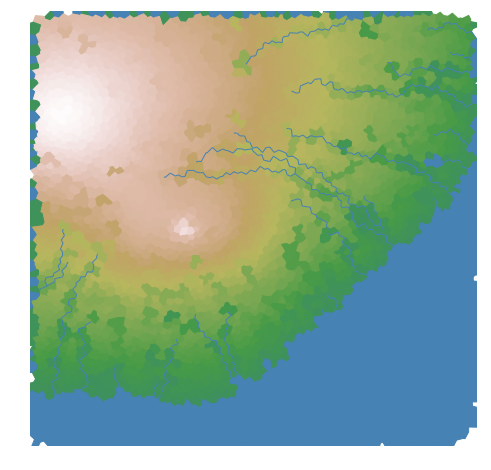

In [5]:
world.draw_world(river_cutoff=0.01)

# Enter the nameless nomads

Simulate nomadic tribes wandering the world; each step, the tribes evaluate adjacent patches and decide which one (if any) to move to. When two tribes meet, they merge. The bigger a tribe is (the more times it has joined other tribes) the less likely it is to move.

Wherever the tribes end up after 500 years is where the cities are.

In [6]:
from NomadModel import NomadModel

In [7]:
nomad_model = NomadModel(world, 1000)

In [8]:
for i in range(500):
    nomad_model.one_year()

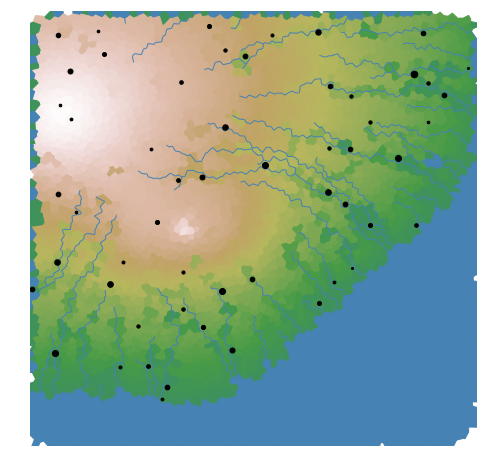

In [9]:
fig, ax = plt.subplots(figsize=(8,8))

world.draw_world(river_cutoff=0.005, ax=ax)

for tribe in nomad_model.nomads:
    x, y = tribe.patch.centroid
    ax.scatter([x], [y], s=tribe.size, c='k', zorder=2)

## Create cities

The tribe locations become city locations. Each city trades with the closest other city that is larger than itself; these trade routes become roads.

In [10]:
class City:
    def __init__(self, patch, size):
        self.name = patch.name
        self.size = size
        self.patch = patch
        self.centroid = np.array(patch.centroid)

In [11]:
cities = [City(tribe.patch, tribe.size) for tribe in nomad_model.nomads]

In [12]:
trade_routes = []
for city in sorted(cities, key=lambda c: c.size)[:-1]:
    bigger_cities = [c for c in cities if c.size > city.size
                    if c != city]
    closest = min(bigger_cities, 
                key=lambda c: np.linalg.norm(city.centroid - c.centroid))
    trade_routes.append((city.name, closest.name))

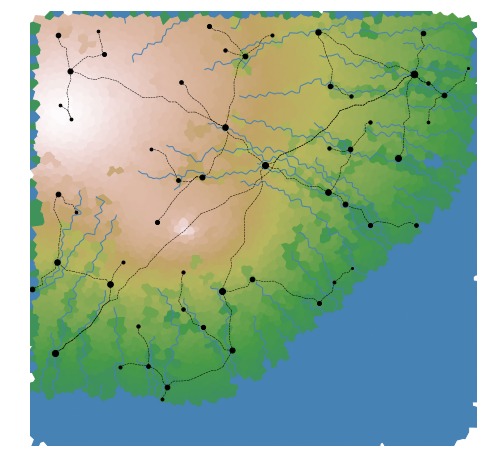

In [13]:
fig, ax = plt.subplots(figsize=(8,8))

world.draw_world(river_cutoff=0.005, ax=ax)

for city in cities:
    x, y = city.patch.centroid
    ax.scatter([x], [y], s=city.size, c='k', zorder=2)

#for start, end in combinations(cities, 2):
for route in trade_routes:
    start, end = route
    if start == end: continue
    road_lines = world.make_road(start, end)
    road_lc = LineCollection(road_lines, colors='k',
                             linewidths=0.5, linestyles="--")
    ax.add_collection(road_lc)

### Prepare network

Build the graph of city to city roads; this graph is used to instantiate the Tribute Model, and simulate how the cities rise and fall.

In [14]:
G = nx.Graph()
for city in cities:
    G.add_node(city.name, wealth=city.size*10)
for c1, c2 in trade_routes:
    G.add_edge(c1, c2)

Give the cities more interesting (random) names

In [15]:
from TributeNarrative import make_word

In [16]:
G = nx.relabel_nodes(G, lambda x: make_word())

## Tribute Model

Simulate how the cities grow, fight, and ally with one another, and log their histories.

In [17]:
from TributeModel import Model
import pandas as pd

In [18]:
tribute_model = Model(G)

In [19]:
for i in range(100):
    tribute_model.step()

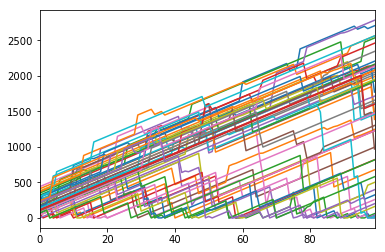

In [20]:
wealth_series = {a.name: a.wealth_history for a in tribute_model.agents.values()}
df = pd.DataFrame(wealth_series)
df.plot(legend=False)

In [21]:
a = max(df.columns, key=lambda x: df[x].max())
print("The wealthiest city is {}".format(a))

The wealthiest city is Iaioai


### Choose a city at random and show its history

In [22]:
a = np.random.choice(df.columns)
print(a)

Xypux


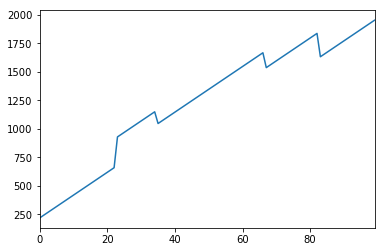

In [23]:
df[a].plot()

### Narrative
Generate a history narrative by finding the local extrema in the city's wealth time series, using them to divide its history into eras, and report the events that occured in each era.

In [24]:
from TributeNarrative import get_eras, write_era

In [25]:
a = tribute_model.agents[a]

In [26]:
eras = get_eras(np.array(a.wealth_history))

In [27]:
for era in eras:
    print(write_era(a, era))
    print("")

From 0 to 66, Xypux saw slow growth. In this period it fought a war against Taiju and received tributes from Taiju.

From 66 to 82, Xypux saw slow growth. In this period it fought a war against Icaoor.

From 82 to 83, Xypux saw rapid decline. In 83 it fought a war against Icaoor.

From 83 to 99, Xypux saw slow growth. 



In [28]:
a.log

[(23, 'Receive tribute', 'Taiju'),
 (35, 'Led war against', 'Taiju'),
 (67, 'Led war against', 'Icaoor'),
 (83, 'Led war against', 'Icaoor')]